# Text Processing - Yelp 2021

## Imports and Global Settings

In [95]:
# Common Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Main NLP libraries
import nltk
import gensim
# Wordclouds
from wordcloud import WordCloud, STOPWORDS
# Reading Level and Basic Stats
import textstat
from nltk.corpus import stopwords as nltk_stopwords
# Sentiment Analysis
from textblob import TextBlob
# Parts of Speech, Named Entities, Syntactic Dependencies
import spacy
# Classification
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
#
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
# Word2Vec
from gensim.models import Word2Vec
import gensim.downloader as api


pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Import Data

In [2]:
file_location = "../data/full_data/analytics_ready/"
filename = "text_data.json"

In [3]:
# 6907890 records available
num_records_to_load = 1000

In [4]:
df = pd.read_json(file_location + filename, nrows=num_records_to_load, orient="records", lines=True)

## Pre-Processing

In [5]:
df.head(5)

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         1000 non-null   object
 1   review_stars      1000 non-null   int64 
 2   review_text       1000 non-null   object
 3   target_ufc_bool   1000 non-null   object
 4   target_ufc_count  1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [7]:
df.target_ufc_bool.value_counts()

True     546
False    454
Name: target_ufc_bool, dtype: int64

## Splitting Text

In [8]:
corpus = df.review_text
text_target = df[['target_ufc_bool', 'review_text']]
Q_corpus = df[df["target_ufc_bool"] == "True"]["review_text"]
NQ_corpus = df[df["target_ufc_bool"] == "False"]["review_text"]
print(f'Corpus Size: Total:{corpus.size}, Quality:{Q_corpus.size}, Not Quality:{NQ_corpus.size}')

Corpus Size: Total:1000, Quality:546, Not Quality:454


## WordClouds

### Wordcloud Stopwords

In [9]:
stopwords = set(STOPWORDS)
stopwords.update([])

#### Join Corpus Into One String

In [10]:
Q_text = " ".join(review for review in Q_corpus)
NQ_text = " ".join(review for review in NQ_corpus)

### Make Wordclouds

In [11]:
Q_wordcloud = WordCloud(stopwords=stopwords, background_color="cornflowerblue", colormap="Set1",
                      collocations=False, color_func=lambda *args, **kwargs: "black",
                      width=1000, height=1000).generate(Q_text)

In [12]:
NQ_wordcloud = WordCloud(stopwords=stopwords, background_color="lightcoral", colormap="Set1",
                      collocations=False, color_func=lambda *args, **kwargs: "black",
                      width=1000, height=1000).generate(NQ_text)

### Save and Show Wordclouds

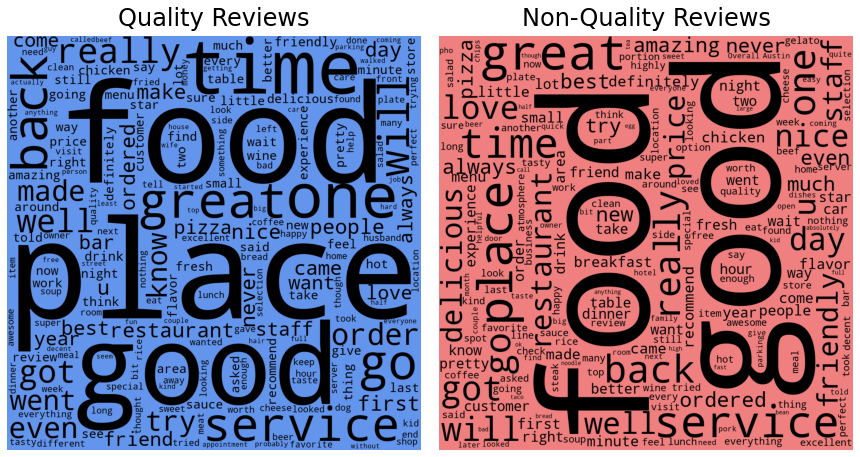

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.imshow(Q_wordcloud)
ax1.axis("off")
ax1.set_title("Quality Reviews", fontsize=24, pad=10)


ax2.imshow(NQ_wordcloud)
ax2.axis("off")
ax2.set_title("Non-Quality Reviews", fontsize=24, pad=10)

fig.tight_layout(pad=0)

# plt.savefig('../images/review_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

## Basic Info

In [14]:
text = df.copy()

#### Feature Creation Stopwords

In [15]:
feature_stopwords = nltk_stopwords.words('english')

In [16]:
text['word_count'] = text['review_text'].apply(lambda x: len(str(x).split(" ")))
text['character_count'] = text['review_text'].str.len()

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

text['avg_word_length'] = text['review_text'].apply(lambda x: avg_word(x))
text['num_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
text['uppercase_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
text['#_@_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@')]))
text['stopword_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x in feature_stopwords]))

In [17]:
text["sentence_count"] = text["review_text"].apply(textstat.sentence_count)
text["lexicon_count"] = text["review_text"].apply(textstat.lexicon_count)
text["syllable_count"] = text["review_text"].apply(textstat.syllable_count)

In [18]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         1000 non-null   object 
 1   review_stars      1000 non-null   int64  
 2   review_text       1000 non-null   object 
 3   target_ufc_bool   1000 non-null   object 
 4   target_ufc_count  1000 non-null   int64  
 5   word_count        1000 non-null   int64  
 6   character_count   1000 non-null   int64  
 7   avg_word_length   1000 non-null   float64
 8   num_count         1000 non-null   int64  
 9   uppercase_count   1000 non-null   int64  
 10  #_@_count         1000 non-null   int64  
 11  stopword_count    1000 non-null   int64  
 12  sentence_count    1000 non-null   int64  
 13  lexicon_count     1000 non-null   int64  
 14  syllable_count    1000 non-null   int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 117.3+ KB


,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,stopword_count,sentence_count,lexicon_count,syllable_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,12,3,37,47
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,39,6,98,138
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,20,4,44,62
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,52,1,110,143
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,6,3,19,24


## Reading Level

In [19]:
text["grade_level"] = text["review_text"].apply(textstat.flesch_kincaid_grade)

In [20]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         1000 non-null   object 
 1   review_stars      1000 non-null   int64  
 2   review_text       1000 non-null   object 
 3   target_ufc_bool   1000 non-null   object 
 4   target_ufc_count  1000 non-null   int64  
 5   word_count        1000 non-null   int64  
 6   character_count   1000 non-null   int64  
 7   avg_word_length   1000 non-null   float64
 8   num_count         1000 non-null   int64  
 9   uppercase_count   1000 non-null   int64  
 10  #_@_count         1000 non-null   int64  
 11  stopword_count    1000 non-null   int64  
 12  sentence_count    1000 non-null   int64  
 13  lexicon_count     1000 non-null   int64  
 14  syllable_count    1000 non-null   int64  
 15  grade_level       1000 non-null   float64
dtypes: float64(2), int64(11), object(3)
memory 

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,stopword_count,sentence_count,lexicon_count,syllable_count,grade_level
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,12,3,37,47,4.50000
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,39,6,98,138,7.30000
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,20,4,44,62,5.20000
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,52,1,110,143,42.70000
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,6,3,19,24,2.20000


## Sentiment Analysis

In [21]:
text["polarity"] = text["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
text["subjectivity"] = text["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [22]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         1000 non-null   object 
 1   review_stars      1000 non-null   int64  
 2   review_text       1000 non-null   object 
 3   target_ufc_bool   1000 non-null   object 
 4   target_ufc_count  1000 non-null   int64  
 5   word_count        1000 non-null   int64  
 6   character_count   1000 non-null   int64  
 7   avg_word_length   1000 non-null   float64
 8   num_count         1000 non-null   int64  
 9   uppercase_count   1000 non-null   int64  
 10  #_@_count         1000 non-null   int64  
 11  stopword_count    1000 non-null   int64  
 12  sentence_count    1000 non-null   int64  
 13  lexicon_count     1000 non-null   int64  
 14  syllable_count    1000 non-null   int64  
 15  grade_level       1000 non-null   float64
 16  polarity          1000 non-null   float64
 

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,stopword_count,sentence_count,lexicon_count,syllable_count,grade_level,polarity,subjectivity
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,12,3,37,47,4.50000,0.45333,0.54333
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,39,6,98,138,7.30000,0.16399,0.51190
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,20,4,44,62,5.20000,0.47396,0.55833
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,52,1,110,143,42.70000,0.23874,0.61131
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,6,3,19,24,2.20000,0.40000,0.85000


## Linguistic Components with Spacy

In [23]:
pos_list = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "DET", "INTJ", "NOUN", "NUM",
            "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X",]
dep_list = ["ROOT", "acl", "acomp", "advcl", "advmod", "agent", "amod",
            "appos", "attr", "aux", "auxpass", "case", "cc", "ccomp",
            "compound", "conj", "csubj", "csubjpass", "dative", "dep", "det",
            "dobj", "expl", "intj", "mark", "meta", "neg", "nmod", "npadvmod",
            "nsubj", "nsubjpass", "nummod", "oprd", "parataxis", "pcomp",
            "pobj", "poss", "preconj", "predet", "prep", "prt", "punct",
            "quantmod", "relcl","xcomp"]
ent_list = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
            "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON",
            "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]

In [24]:
def create_spacy_features(df, text_feature_name):
    """
    Adds various features using Spacy's library and NLP models.

    Key Terms:
        pos_dict: Part of Speech
                  https://universaldependencies.org/u/pos/

        dep_list: Universal Dependency Relations
                  https://universaldependencies.org/u/dep/

        ent_list: Named Entity
                  https://spacy.io/api/annotation#named-entities
    """
    nlp = spacy.load("en_core_web_sm")

    df["spacy_doc"] = df[text_feature_name].apply(lambda x: nlp(x))
    df["spacy_token_count"] = df["spacy_doc"].apply(lambda x: len(x))
    df["spacy_perc_stop_words"] = df["spacy_doc"].apply(lambda x: round(len([token for token in x if token.is_stop]) / len(x), 5))
    df["spacy_perc_ent"] = df["spacy_doc"].apply(lambda x: round(len([token for token in x.ents]) / len(x), 5))

    for pos in pos_list:
        df[f"spacy_perc_{pos.lower()}"] = df["spacy_doc"].apply(
            lambda x: round(len([token for token in x if token.pos_ == pos]) / len(x), 2))

    for dep in dep_list:
        df[f"spacy_perc_{dep.lower()}"] = df["spacy_doc"].apply(
            lambda x: round(len([token for token in x if token.dep_ == dep]) / len(x), 2))
    
    for ent in ent_list:
        df[f"spacy_perc_{ent.lower()}"] = df["spacy_doc"].apply(
            lambda x: round(len([y for y in x.ents if y.label_ == ent]) / len(x), 2))
    
    df.drop("spacy_doc", axis=1, inplace=True)
    
    return df

In [25]:
text = create_spacy_features(text, 'review_text')

In [26]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 96 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   review_id               1000 non-null   object 
 1   review_stars            1000 non-null   int64  
 2   review_text             1000 non-null   object 
 3   target_ufc_bool         1000 non-null   object 
 4   target_ufc_count        1000 non-null   int64  
 5   word_count              1000 non-null   int64  
 6   character_count         1000 non-null   int64  
 7   avg_word_length         1000 non-null   float64
 8   num_count               1000 non-null   int64  
 9   uppercase_count         1000 non-null   int64  
 10  #_@_count               1000 non-null   int64  
 11  stopword_count          1000 non-null   int64  
 12  sentence_count          1000 non-null   int64  
 13  lexicon_count           1000 non-null   int64  
 14  syllable_count          1000 non-null   i

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,...,spacy_perc_money,spacy_perc_norp,spacy_perc_ordinal,spacy_perc_org,spacy_perc_percent,spacy_perc_person,spacy_perc_product,spacy_perc_quantity,spacy_perc_time,spacy_perc_work_of_art
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,...,0.00000,0.05000,0.02000,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.00000
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,...,0.00000,0.00000,0.01000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,...,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Classification Using Classical Machine Learning and Text Vectorization - Tf-Idf

In [27]:
baseline_cls_data = df[['review_text', 'target_ufc_bool']]
baseline_cls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      1000 non-null   object
 1   target_ufc_bool  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [28]:
X = baseline_cls_data.review_text
y = baseline_cls_data.target_ufc_bool

In [29]:
scoring = {'roc_auc': 'roc_auc',
           'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, pos_label="True"),
           'recall': make_scorer(recall_score, pos_label="True")}

In [30]:
def display_clf_results(cv_clf):
    print('Model Performance')
    print(f'Fit Time: {np.mean(cv_clf["fit_time"]):.2f} secs, Score Time: {np.mean(cv_clf["score_time"]):.2f} secs')
    print(f'Accuracy: {np.mean(cv_clf["test_accuracy"]):.2f}')
    print(f'ROC AUC: {np.mean(cv_clf["test_roc_auc"]):.2f}')
    print(f'Precision: {np.mean(cv_clf["test_precision"]):.2f}')
    print(f'Recall: {np.mean(cv_clf["test_recall"]):.2f}')

### Word Count Baseline

In [31]:
word_count_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

In [32]:
wc_results = cross_validate(word_count_pipeline, X, y, cv=5, scoring=scoring)

In [33]:
display_clf_results(wc_results)

Model Performance
Fit Time: 0.08 secs, Score Time: 0.03 secs
Accuracy: 0.57
ROC AUC: 0.60
Precision: 0.58
Recall: 0.74


### Tf-idf Baseline

In [34]:
tfidf_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [35]:
tfidf_results = cross_validate(tfidf_pipeline, X, y, cv=5, scoring=scoring)

In [36]:
display_clf_results(tfidf_results)

Model Performance
Fit Time: 0.07 secs, Score Time: 0.03 secs
Accuracy: 0.55
ROC AUC: 0.61
Precision: 0.55
Recall: 0.98


### Tf-idf Grid Search Hyperparameter Tuning

In [37]:
tfidf_grid_cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

tfidf_grid_cv_params = {
    'vect__strip_accents': [None, 'unicode'],
    'vect__lowercase': [True, False],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__norm': ['l1', 'l2'],
    'clf__fit_prior': [True, False],
    'clf__alpha': [0.1, 0.5, 1, 2, 5, 100]
}

tfidf_grid_cv_params_short = {
    'vect__strip_accents': [None],
    'vect__lowercase': [True],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,2)],
    'tfidf__norm': ['l1', 'l2'],
    'clf__fit_prior': [True],
    'clf__alpha': [0.1, 1, 10]
}

In [38]:
# Too many fits. Need to reduce parameter combos.
tfidf_grid_cv_MNB = GridSearchCV(tfidf_grid_cv_pipeline, tfidf_grid_cv_params_short,
                      n_jobs=-1, cv=5, scoring=scoring, refit='accuracy', verbose=5)
tfidf_grid_cv_MNB.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 1, 10], 'clf__fit_prior': [True],
                         'tfidf__norm': ['l1', 'l2'], 'vect__lowercase': [True],
                         'vect__ngram_range': [(1, 2)],
                         'vect__stop_words': [None, 'english'],
                         'vect__strip_accents': [None]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision': make_scorer(precision_score, pos_label=True),
                      'recall': make_scorer(recall_score, pos_label=True),
                      'roc_auc': 'roc_auc'},
             verbose=5)

In [39]:
idx = tfidf_grid_cv_MNB.best_index_
results = tfidf_grid_cv_MNB.cv_results_

In [40]:
def display_clf_grid_search_results(cv_clf_gs, best_idx):
    print('Model Performance')
    print(f'Fit Time: {cv_clf_gs["mean_fit_time"][best_idx]:.2f} secs, Score Time: {cv_clf_gs["mean_score_time"][best_idx]:.2f} secs')
    print(f'Accuracy: {cv_clf_gs["mean_test_accuracy"][best_idx]:.2f}')
    print(f'ROC AUC: {cv_clf_gs["mean_test_roc_auc"][best_idx]:.2f}')
    print(f'Precision: {cv_clf_gs["mean_test_precision"][best_idx]:.2f}')
    print(f'Recall: {cv_clf_gs["mean_test_recall"][best_idx]:.2f}')
    print('Best model choosen using accuracy.')
    print(f'Best ROC AUC: {max(cv_clf_gs["mean_test_roc_auc"]):.2f}')
    print(f'Best Precision: {max(cv_clf_gs["mean_test_precision"]):.2f}')
    print(f'Best Recall: {max(cv_clf_gs["mean_test_recall"]):.2f}')

In [41]:
display_clf_grid_search_results(results, idx)

Model Performance
Fit Time: 0.50 secs, Score Time: 0.13 secs
Accuracy: 0.55
ROC AUC: 0.55
Precision: 0.55
Recall: 1.00
Best model choosen using accuracy.
Best ROC AUC: 0.64
Best Precision: 0.56
Best Recall: 1.00


## Topic Modeling - NMF, LDA

### Data Overview

In [42]:
tt = text_target.copy()
tt.info()
tt.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   target_ufc_bool  1000 non-null   object
 1   review_text      1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


,target_ufc_bool,review_text
0,False,Been looking for a halfway decent Chinese/Amer...
1,False,I visited Kyma last week for the first time an...
2,False,It might be the most expensive gelato I've eve...
3,True,"Love this place! They have great antiques, be..."
4,False,Great salad and cold sandwich.. The soup is am...


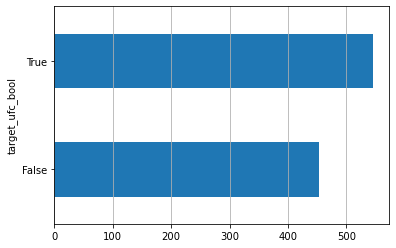

True     546
False    454
Name: target_ufc_bool, dtype: int64

In [43]:
fig, ax = plt.subplots()
tt["target_ufc_bool"].reset_index().groupby("target_ufc_bool").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()
tt['target_ufc_bool'].value_counts()

### Preprocess Text

In [55]:
def preprocess_text(text, run_stemm=True, run_lemm=True, remove_num=False, stopwords=None):
    '''
    Preprocess a string.
    parameters:
        text: string - name of column containing text
        stopwords: list - list of stopwords to remove
        run_stemm: bool - whether stemming is to be applied
        run_lemm: bool - whether lemmatization is to be applied
        remove_num: bool - whether to remove numbers or not
    output
        cleaned text
    '''
    # Lowercase, Remove Punc and Special Characters, and Strip Whitespace
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # Remove Numbers
    if remove_num:
        text = re.sub(r'[0-9]', '', str(text))
    
    ## Tokenize (convert from string to list)
    text_lst = text.split()
    
    ## Remove Stopwords
    if stopwords is not None:
        text_lst = [word for word in text_lst if word not in stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if run_stemm:
        stemmer = nltk.stem.porter.PorterStemmer()
        text_lst = [stemmer.stem(word) for word in text_lst]
                
    ## Lemmatisation (convert word into root word)
    if run_lemm:
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        text_lst = [lemma.lemmatize(word) for word in text_lst]
            
    ## back to string from list
    text = " ".join(text_lst)
    return text

In [56]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [46]:
tt["review_text_clean"] = tt["review_text"].apply(lambda x: 
          preprocess_text(x, run_stemm=False, run_lemm=True, 
          stopwords=lst_stopwords))
tt.head()

,target_ufc_bool,review_text,review_text_clean
0,False,Been looking for a halfway decent Chinese/Amer...,looking halfway decent chineseamerican food pl...
1,False,I visited Kyma last week for the first time an...,visited kyma last week first time really enjoy...
2,False,It might be the most expensive gelato I've eve...,might expensive gelato ive ever doubt best eve...
3,True,"Love this place! They have great antiques, be...",love place great antique beautiful clock colle...
4,False,Great salad and cold sandwich.. The soup is am...,great salad cold sandwich soup amazing well al...


### Train Test Split

In [47]:
tt_X_train, tt_X_test, tt_y_train, tt_y_test = train_test_split(tt['review_text_clean'],
                                                                tt['target_ufc_bool'],
                                                                test_size=0.30, random_state=42)

### Tf-Idf

In [48]:
tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
tfidf_vect.fit(tt_X_train)
tt_X_train_vect = tfidf_vect.transform(tt_X_train)
dic_vocabulary = tfidf_vect.vocabulary_

### --Needs Work-- Feature Reduction Using Chi-Squared Test

In [49]:
X_names = tfidf_vect.get_feature_names()
p_value_limit = 0.50
dtf_features = pd.DataFrame()
for category in np.unique(tt_y_train):
    _, p_value = chi2(tt_X_train_vect, tt_y_train==category)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p_value, "target_category":category}))
    dtf_features = dtf_features.sort_values(["target_category","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"] > p_value_limit]
X_names_reduced = dtf_features["feature"].unique().tolist()

In [50]:
for cat in np.unique(tt_y_train):
    print(f'# {cat}')
    print("  . selected features:",
         len(dtf_features[dtf_features["target_category"]==cat]))
    print("  . top features:", ",".join(
    dtf_features[dtf_features["target_category"]==cat]["feature"].values[:10]))
    print(" ")

# False
  . selected features: 384
  . top features: least,bar,taco,food option,best part,gelato,breakfast burrito,tasted good,expensive,taiwanese
 
# True
  . selected features: 384
  . top features: least,bar,taco,food option,best part,gelato,breakfast burrito,tasted good,expensive,taiwanese
 


In [51]:
tt_X_train

541    cannot go wrong high quality beef dog nice var...
440    wish could give place zero star ordered online...
482    really good dinner one newer place disney spri...
422    fiance go month first date first time lemon dr...
778    place right frequent lunch special consists 1m...
                             ...                        
106    food 55 think food good authentic bun mam bun ...
270    service excellent food brought 2 star love woo...
860    ive wanting try food ever since ive seen food ...
435    professional service friendly warm staff great...
102    sat afternoon dec 15 2018 ordered best meze pl...
Name: review_text_clean, Length: 700, dtype: object

In [52]:
chi2_vect = TfidfVectorizer(vocabulary=X_names_reduced)

In [53]:
def run_basic_tfidf_mnb_cv_modeling(vectorizer, X, y):
    scoring = {'roc_auc': 'roc_auc',
           'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, pos_label="True"),
           'recall': make_scorer(recall_score, pos_label="True")}

    tfidf_mnb_pipeline = Pipeline([
        ('tfidf_vect', vectorizer),
        ('clf', MultinomialNB())
    ])
    
    results = cross_validate(tfidf_mnb_pipeline, X, y, cv=5, scoring=scoring)

    display_clf_results(results)

In [54]:
run_basic_tfidf_mnb_cv_modeling(chi2_vect, tt_X_test, tt_y_test)

Model Performance
Fit Time: 0.03 secs, Score Time: 0.02 secs
Accuracy: 0.53
ROC AUC: 0.52
Precision: 0.53
Recall: 0.51


## Classification Using Word Embeddings - Word2Vec, Deep Learning

## Word2Vec

### Preprocessing

In [58]:
w2v_df = text_target.copy()

In [60]:
w2v_df['review_text_clean'] = w2v_df['review_text'].apply(lambda x: preprocess_text(x, run_stemm=False,
                                                                                   run_lemm=False,
                                                                                   remove_num=True,
                                                                                   stopwords=None))

In [71]:
w2v_df['clean_text_lst'] = w2v_df['review_text_clean'].apply(lambda x: x.split())

In [72]:
w2v_df.head()

,target_ufc_bool,review_text,review_text_clean,clean_text_lst
0,False,Been looking for a halfway decent Chinese/Amer...,been looking for a halfway decent chineseameri...,"[been, looking, for, a, halfway, decent, chine..."
1,False,I visited Kyma last week for the first time an...,i visited kyma last week for the first time an...,"[i, visited, kyma, last, week, for, the, first..."
2,False,It might be the most expensive gelato I've eve...,it might be the most expensive gelato ive ever...,"[it, might, be, the, most, expensive, gelato, ..."
3,True,"Love this place! They have great antiques, be...",love this place they have great antiques beaut...,"[love, this, place, they, have, great, antique..."
4,False,Great salad and cold sandwich.. The soup is am...,great salad and cold sandwich the soup is amaz...,"[great, salad, and, cold, sandwich, the, soup,..."


### All Text Combined

In [75]:
all_text = " ".join(w2v_df['review_text_clean'])
all_text_lst = [x for x in w2v_df['clean_text_lst']]
all_text_lst

[['been',
  'looking',
  'for',
  'a',
  'halfway',
  'decent',
  'chineseamerican',
  'food',
  'place',
  'this',
  'is',
  'the',
  'third',
  'one',
  'ive',
  'tried',
  'and',
  'by',
  'far',
  'the',
  'best',
  'one',
  'the',
  'vegetable',
  'fried',
  'rice',
  'was',
  'eh',
  'but',
  'the',
  'chow',
  'mien',
  'and',
  'crab',
  'rangoon',
  'was',
  'great'],
 ['i',
  'visited',
  'kyma',
  'last',
  'week',
  'for',
  'the',
  'first',
  'time',
  'and',
  'really',
  'enjoyed',
  'it',
  'the',
  'menu',
  'overwhelms',
  'you',
  'a',
  'bit',
  'but',
  'we',
  'had',
  'the',
  'meze',
  'menu',
  'which',
  'provides',
  'a',
  'great',
  'sampling',
  'the',
  'grilled',
  'octopus',
  'and',
  'lamb',
  'pie',
  'were',
  'definitely',
  'my',
  'favorites',
  'but',
  'everything',
  'was',
  'great',
  'i',
  'was',
  'a',
  'little',
  'worried',
  'it',
  'would',
  'not',
  'be',
  'enough',
  'food',
  'and',
  'considered',
  'getting',
  'the',
  'whol

In [77]:
word2vec_model = Word2Vec(all_text_lst, min_count=2)

In [91]:
word2vec_model.wv.most_similar('good', topn=10)

[('great', 0.9991955161094666),
 ('food', 0.9990870952606201),
 ('friendly', 0.9989845752716064),
 ('nice', 0.9989492893218994),
 ('very', 0.9989254474639893),
 ('service', 0.9988318681716919),
 ('is', 0.998590886592865),
 ('staff', 0.9984208345413208),
 ('excellent', 0.9981484413146973),
 ('delicious', 0.9979516863822937)]

In [87]:
word2vec_model.wv.('good', 'beef')

0.9960398

In [101]:
api.info('word2vec-google-news-300')

{'num_records': 3000000,
 'file_size': 1743563840,
 'base_dataset': 'Google News (about 100 billion words)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/word2vec-google-news-300/__init__.py',
 'license': 'not found',
 'parameters': {'dimension': 300},
 'description': "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",
 'read_more': ['https://code.google.com/archive/p/word2vec/',
  'https://arxiv.org/abs/1301.3781',
  'https://arxiv.org/abs/1310.4546',
  'https://www.microsoft.com/en-us/research/publication/linguistic-regularities-in-continuous-space-word-representations/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F189726%2Frvec

In [103]:
# Overloads
# pre_trained_word2vec_model = api.load('word2vec-google-news-300')

KeyboardInterrupt: 